In [1]:
import numpy as np
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

%matplotlib inline

In [2]:
team_lookup = pickle.load(open('teams_lookup.pickle', "rb" ))
df = pickle.load(open('final_19.pickle', "rb" ))

In [3]:
cols = df.columns.tolist()
target = 'Spread'
all_predictors = ['Home', 'Away', 'Wins', 'Tm', 'Opp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
                   'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%',
                   'STL%', 'BLK%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'P_S', 'FG_S',
                   'FGA_S', 'FG%_S', '3P_S', '3PA_S', '3P%_S', 'FT_S', 'FTA_S', 'FT%_S', 'TRB_S', 'AST_S', 'STL_S', 'BLK_S',
                   'TOV_S', 'PF_S', 'FTr_S', '3PAr_S', 'TS%_S', 'TRB%_S', 'AST%_S', 'STL%_S', 'BLK%_S',
                   'Home_vs', 'Away_vs', 'Wins_vs', 'Tm_vs', 'Opp_vs', 'FG_vs', 'FGA_vs', 'FG%_vs', '3P_vs', '3PA_vs',
                   '3P%_vs', 'FT_vs', 'FTA_vs', 'FT%_vs', 'ORB_vs', 'TRB_vs', 'AST_vs', 'STL_vs', 'BLK_vs', 'TOV_vs',
                   'PF_vs', 'ORtg_vs', 'DRtg_vs', 'Pace_vs', 'FTr_vs', '3PAr_vs', 'TS%_vs', 'TRB%_vs', 'AST%_vs',
                   'STL%_vs', 'BLK%_vs', 'OeFG%_vs', 'OTOV%_vs', 'ORB%_vs', 'OFT/FGA_vs', 'DeFG%_vs', 'DTOV%_vs',
                   'DRB%_vs', 'DFT/FGA_vs', 'P_S_vs', 'FG_S_vs', 'FGA_S_vs', 'FG%_S_vs', '3P_S_vs', '3PA_S_vs',
                   '3P%_S_vs', 'FT_S_vs', 'FTA_S_vs', 'FT%_S_vs', 'TRB_S_vs', 'AST_S_vs', 'STL_S_vs', 'BLK_S_vs',
                   'TOV_S_vs', 'PF_S_vs', 'FTr_S_vs', '3PAr_S_vs', 'TS%_S_vs', 'TRB%_S_vs', 'AST%_S_vs', 'STL%_S_vs',
                   'BLK%_S_vs']
info_cols = ['url','Team','Date','Opponent','Win_Loss','GP','GP_vs']

In [4]:
def TVT_split(df, train_min = 12, val_min = 24, test_min = 28):
    
    df_train = df[(df.GP >= train_min) & (df.GP_vs >= train_min) & (df.GP <= (val_min -1))] 
    df_val = df[(df.GP >= val_min) & (df.GP <= (test_min -1))] 
    df_test = df[df.GP >= test_min]
    
    total = len(df)
    train = len(df_train)
    val = len(df_val)
    test = len(df_test)
    mature = train + val + test
    immature = total - mature
    
    
    splits = [['dataset','games','percent of total'],['total', total ,'1'],['immature', immature, immature/total],
               ['mature', mature, mature/total], ['dataset','games','percent of mature'], ['train', train, train/mature],
               ['val', val, val/mature], ['test', test, test/mature]]
    print(splits)
    return df_train, df_val, df_test

In [5]:
df_train, df_val, df_test = TVT_split(df)

[['dataset', 'games', 'percent of total'], ['total', 5603, '1'], ['immature', 2213, 0.39496698197394253], ['mature', 3390, 0.6050330180260575], ['dataset', 'games', 'percent of mature'], ['train', 2020, 0.5958702064896755], ['val', 706, 0.20825958702064898], ['test', 664, 0.1958702064896755]]


In [6]:
sc = StandardScaler()

In [7]:
def preprocess(df_train, df_val, df_test):
    '''
    pre-process the data...
    '''
    # get predictor columns
    X_train = df_train[all_predictors]
    X_val = df_val[all_predictors]
    X_test = df_test[all_predictors]
    
    #scale all predictors using training data
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    X_test = sc.transform(X_test)
    
    #add constants
    X_train = sm.add_constant(X_train)
    X_val = sm.add_constant(X_val)
    X_test = sm.add_constant(X_test)
    
    #convert back to data frame
    X_train = pd.DataFrame(X_train, columns = ['const']+all_predictors,index = df_train.index)
    X_val = pd.DataFrame(X_val, columns = ['const']+all_predictors, index = df_val.index)
    X_test = pd.DataFrame(X_test, columns = ['const']+all_predictors, index = df_test.index)
        
        
    #get targets
    y_train = pd.DataFrame(df_train['Spread'])
    y_val = pd.DataFrame(df_val['Spread'])
    y_test = pd.DataFrame(df_test['Spread'])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess(df_train, df_val, df_test)

In [9]:
X_train

,const,Home,Away,Wins,Tm,Opp,FG,FGA,FG%,3P,...,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
1625,1.0,0.997034,-0.991128,1.559060,3.527563,0.753101,3.307920,1.521976,2.679847,0.722512,...,0.060275,1.651806,0.522882,-0.659338,-0.635573,-0.463281,0.435048,-0.503044,-0.311881,0.055804
1030,1.0,-1.002975,-0.991128,1.165405,1.822559,-0.315349,2.360853,1.833235,1.291932,0.114387,...,0.875660,-0.464008,-0.979431,0.345986,1.704508,0.573749,1.268263,0.396825,-0.515645,0.806104
790,1.0,0.997034,-0.991128,1.559060,0.216191,-2.466689,0.466720,-0.475271,0.926103,-1.405927,...,-2.134991,0.805481,0.957762,-1.139020,-0.822246,-2.487345,-0.302511,-2.162751,-0.989290,-2.098159
4968,1.0,-1.002975,1.008951,1.165405,0.018918,-0.835136,-0.253051,-1.383110,0.959614,-0.919427,...,0.311163,2.459662,1.471711,-1.298917,0.403851,-0.770609,-0.712826,-0.818520,-2.303596,0.288770
2473,1.0,-1.002975,1.008951,-0.802867,0.343009,1.301765,0.353072,-0.138073,0.454157,-0.432926,...,-0.065168,-2.272067,0.404279,-0.244355,-1.038691,1.909164,2.307894,1.916185,0.822022,-0.078389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5580,1.0,0.997034,-0.991128,1.319444,1.442103,0.133500,2.138498,0.776533,1.961303,0.236012,...,-0.624211,-0.263298,1.659071,-2.072422,-0.394415,-0.593238,-0.347275,0.853333,0.742998,-0.655223
1927,1.0,-1.002975,1.008951,-0.939791,-0.072367,1.353869,-0.094932,-0.238443,0.096341,1.156132,...,-0.262984,-0.055641,-0.812169,0.724551,1.492155,0.452549,0.405228,0.327582,-0.944812,-0.295852
700,1.0,0.997034,-0.991128,-0.118251,0.640757,0.540290,0.280601,0.086349,0.333833,0.870577,...,-0.320881,0.778848,-0.921649,1.414710,-0.396597,1.225339,0.658504,-0.073147,-0.673875,-0.320343
4608,1.0,-1.002975,1.008951,0.497904,-0.476716,-1.139600,0.399190,-0.157245,0.599007,0.045642,...,1.035709,0.698032,-0.939896,1.221023,-1.451939,0.517891,0.686427,-0.135874,0.454871,1.078296


In [10]:
y_train

,Spread
1625,61
1030,-23
790,21
4968,10
2473,-33
...,...
5580,-8
1927,-9
700,-1
4608,-5


## Initial Model - OLS using all stats

In [11]:
# Create your model
model = sm.OLS(y_train,X_train)

# Fit your model to your training set
fit1 = model.fit()
ypred = fit1.predict(X_train)


In [12]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Spread   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     9.158
Date:                Wed, 15 Jul 2020   Prob (F-statistic):          6.26e-117
Time:                        18:55:25   Log-Likelihood:                -7692.3
No. Observations:                2020   AIC:                         1.562e+04
Df Residuals:                    1901   BIC:                         1.629e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.250      0.146      0.884      -0.454       0.527
Home           3.7580      1.190      3.157      0.002       1.423       6.093
Away           2.1619      1.190      1.816      0.069      -0.173       4.496
Wins           0.6724      0.732      0.918      0.359      -0.764       2.108
Tm           -67.9530    102.507     -0.663      0.507    -268.992     133.086
Opp           85.5678    106.440      0.804      0.422    -123.184     294.320
FG           -17.9392    147.405     -0.122      0.903    -307.032     271.154
FGA            8.1458      6.858      1.188      0.235      -5.303      21.595
FG%          -13.0990     22.958     -0.571      0.568     -58.124      31.926
3P           -11.3184     45.974     -0.246      0.806    -101.484      78.847
3PA           -1.8935      7.480     -0.253      0.800     -16.563      12.776
3P%           -0.0199      1.749     -0.011      0.991      -3.450       3.410
FT            18.4410     81.714      0.226      0.821    -141.817     178.699
FTA          -19.7596     10.354     -1.908      0.056     -40.065       0.546
FT%            0.0080      1.147      0.007      0.994      -2.242       2.257
ORB           -4.8199      3.044     -1.583      0.114     -10.791       1.151
TRB            0.8321      2.268      0.367      0.714      -3.616       5.280
AST            0.2543      3.090      0.082      0.934      -5.806       6.315
STL           -9.5212      8.036     -1.185      0.236     -25.282       6.240
BLK           -1.6968      2.628     -0.646      0.519      -6.850       3.457
TOV           -5.1196      6.818     -0.751      0.453     -18.491       8.252
PF             2.6922      1.005      2.678      0.007       0.721       4.664
ORtg          -1.5677      8.578     -0.183      0.855     -18.390      15.255
DRtg           9.2481      8.215      1.126      0.260      -6.863      25.359
Pace           0.5357      1.348      0.397      0.691      -2.108       3.179
FTr          -52.1117    233.747     -0.223      0.824    -510.539     406.316
3PAr           2.3818      6.882      0.346      0.729     -11.116      15.880
TS%          -13.7199     14.453     -0.949      0.343     -42.065      14.625
TRB%          -2.5048      2.361     -1.061      0.289      -7.136       2.127
AST%          -0.3944      2.137     -0.185      0.854      -4.585       3.796
STL%          10.7147      7.625      1.405      0.160      -4.239      25.669
BLK%           2.5732      2.419      1.064      0.288      -2.171       7.318
OeFG%          6.8216     21.182      0.322      0.747     -34.721      48.364
OTOV%          6.3107      5.212      1.211      0.226      -3.910      16.532
ORB%           5.0242      3.473      1.447      0.148      -1.787      11.835
OFT/FGA      -19.8368      9.938     -1.996      0.046     -39.327      -0.346
De

In [13]:
prediction = pd.concat([y_train, ypred, abs(y_train.Spread-ypred)],axis=1)
prediction.columns = ["True","Prediction","Error"]

In [14]:
prediction.Error.mean()

8.576323599439716

In [15]:
valpred = fit1.predict(X_val)

In [16]:
val_prediction = pd.concat([y_val, valpred, abs(y_val.Spread-valpred)],axis=1)
val_prediction.columns = ["True","Prediction","Error"]
val_prediction.Error.mean()

9.33865478556671

In [17]:
testpred = fit1.predict(X_test)
test_prediction = pd.concat([y_test, testpred, abs(y_test.Spread-testpred)],axis=1)
test_prediction.columns = ["True","Prediction","Error"]
test_prediction.Error.mean()

11.394283657228318

## Lasso Regression

In [18]:
fit_lasso = model.fit_regularized(alpha = 0.001,L1_wt = 0,start_params=fit1.params)

In [19]:
final = sm.regression.linear_model.OLSResults(model,fit_lasso.params,model.normalized_cov_params)

In [20]:
print(final.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     8.805
Date:                Wed, 15 Jul 2020   Prob (F-statistic):          9.37e-112
Time:                        18:56:18   Log-Likelihood:                -7706.5
No. Observations:                2020   AIC:                         1.565e+04
Df Residuals:                    1901   BIC:                         1.632e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.252      0.145      0.8

In [ ]:
final.eigenvals

In [32]:
frames = []
for n in np.arange(0, 1, 0.01).tolist():
    results_fr = model.fit_regularized(L1_wt=0, alpha=n, start_params=fit1.params)

    results_fr_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_fr.params)
    frames.append(np.append(results_fr.params, np.mean(abs(y_val.Spread-results_fr.predict(X_val)))))
    df = pd.DataFrame(frames, columns=['const']+all_predictors + ['mae*'])
df.index=np.arange(0, 1, 0.01).tolist()
df.index.name = 'alpha*'
df.T

alpha*,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
const,1.022674e-01,0.036271,0.035915,0.035567,0.035225,0.034889,0.034560,0.034237,0.033920,0.033609,...,0.019281,0.019180,0.019080,0.018981,0.018883,0.018786,0.018691,0.018596,0.018502,0.018409
Home,1.755494e+14,2.349704,1.849792,1.591734,1.433929,1.327168,1.249903,1.191215,1.144984,1.107513,...,0.687933,0.686200,0.684482,0.682777,0.681086,0.679408,0.677743,0.676090,0.674450,0.672822
Away,-2.520897e+14,0.750957,0.255071,0.001358,-0.152065,-0.254476,-0.327442,-0.381885,-0.423924,-0.457253,...,-0.613971,-0.613037,-0.612100,-0.611160,-0.610218,-0.609273,-0.608326,-0.607377,-0.606427,-0.605474
Wins,1.072052e+00,0.813417,0.792593,0.765920,0.740320,0.716953,0.695859,0.676827,0.659607,0.643962,...,0.370503,0.369564,0.368637,0.367723,0.366821,0.365931,0.365052,0.364185,0.363329,0.362483
Tm,5.437479e+13,0.353129,0.298486,0.275149,0.262071,0.253659,0.247773,0.243411,0.240036,0.237337,...,0.203321,0.203139,0.202958,0.202778,0.202600,0.202422,0.202246,0.202070,0.201896,0.201722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRB%_S_vs,-2.315301e+14,-0.364937,-0.421983,-0.428770,-0.424776,-0.418302,-0.411585,-0.405268,-0.399507,-0.394298,...,-0.288626,-0.288018,-0.287415,-0.286817,-0.286224,-0.285635,-0.285051,-0.284472,-0.283897,-0.283326
AST%_S_vs,-1.121467e+01,-0.336245,-0.266146,-0.250169,-0.244948,-0.243241,-0.242967,-0.243345,-0.244030,-0.244855,...,-0.254721,-0.254579,-0.254437,-0.254293,-0.254148,-0.254001,-0.253854,-0.253706,-0.253556,-0.253405
STL%_S_vs,1.185115e+01,0.250188,0.180314,0.146603,0.120373,0.097990,0.078318,0.060772,0.044977,0.030656,...,-0.195431,-0.195826,-0.196209,-0.196579,-0.196938,-0.197285,-0.197621,-0.197946,-0.198261,-0.198566
BLK%_S_vs,-5.141556e+00,-0.188546,-0.008007,0.048738,0.072803,0.083869,0.088695,0.090198,0.089822,0.088351,...,-0.007051,-0.007433,-0.007808,-0.008178,-0.008542,-0.008901,-0.009254,-0.009602,-0.009945,-0.010283


Text(0.5, 1.0, 'MSE')

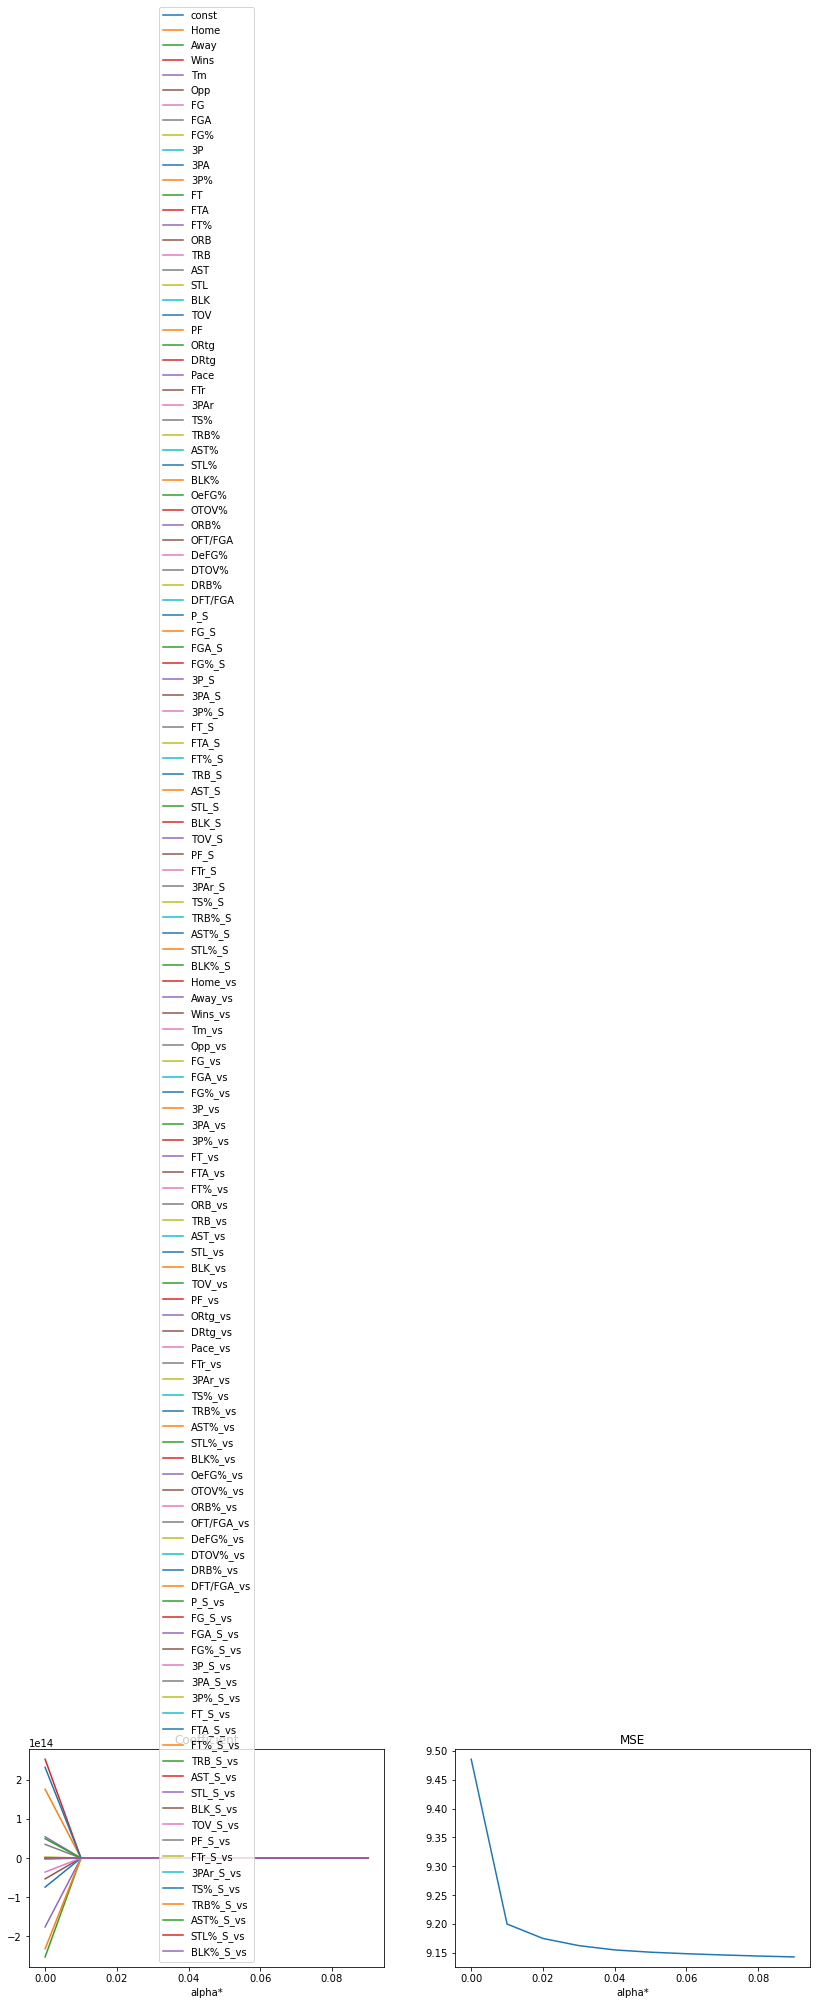

In [31]:

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0] = df.iloc[:10, :-1].plot(ax=ax[0])
ax[0].set_title('Coefficient')

ax[1] = df.iloc[:10, -1].plot(ax=ax[1])
ax[1].set_title('MSE')